#1. 기초적인 라이브러리 import 및 install



In [ ]:
!pip install ace_tools_open

In [ ]:
!pip install fredapi pandas

In [168]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns

# 2. 위키피디아에서 Ticker 와 Sector 를 가져와, 매칭한 정보를 데이터프레임으로

In [ ]:
# Fetch the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
sp500_table = tables[0]

# Extract ticker symbols and sectors
tickers = sp500_table['Symbol'].tolist()
sectors = sp500_table['GICS Sector'].tolist()

# Create a DataFrame
sp500_df = pd.DataFrame({'Ticker': tickers, 'Sector': sectors})

print(sp500_df)
sp500_df.to_csv("sp500_tickers.csv", index=False)

    Ticker                  Sector
0      MMM             Industrials
1      AOS             Industrials
2      ABT             Health Care
3     ABBV             Health Care
4      ACN  Information Technology
..     ...                     ...
497    XYL             Industrials
498    YUM  Consumer Discretionary
499   ZBRA  Information Technology
500    ZBH             Health Care
501    ZTS             Health Care

[502 rows x 2 columns]


## Ticker 를 리스트로 만든 다음, yfinance 를 통해 Sector 정보를 가져온다. <br>혹시 위키피디아와 yfinance 가 다를 수 있기 때문

In [ ]:
ticker_list = sp500_df['Ticker'].values.tolist()

In [ ]:
# Fetch sector information
sector_data = {}
for ticker in ticker_list:
    try:
        stock = yf.Ticker(ticker)
        sector_data[ticker] = stock.info.get('sector', 'Unknown')
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Convert to DataFrame
sector_df = pd.DataFrame(list(sector_data.items()), columns=['Ticker', 'Sector'])

print(sector_df)


    Ticker             Sector
0      MMM        Industrials
1      AOS        Industrials
2      ABT         Healthcare
3     ABBV         Healthcare
4      ACN         Technology
..     ...                ...
497    XYL        Industrials
498    YUM  Consumer Cyclical
499   ZBRA         Technology
500    ZBH         Healthcare
501    ZTS         Healthcare

[502 rows x 2 columns]


## 섹터들의 리스트를 가져온다

In [64]:
sector_list = sector_df['Sector'].unique()

In [65]:
print(sector_list)

['Unknown' 'Healthcare' 'Technology' 'Financial Services'
 'Consumer Defensive' 'Utilities' 'Basic Materials' 'Consumer Cyclical'
 'Industrials' 'Real Estate' 'Energy' 'Communication Services']


In [ ]:
sector_df['Sector'].value_counts()

,count
Sector,
Technology,82
Industrials,70
Financial Services,66
Healthcare,62
Consumer Cyclical,55
Consumer Defensive,36
Utilities,32
Real Estate,31
Basic Materials,22


## 이후, 앞에서 구했던 ticker_list 를 바탕으로 yfinance 에서 2013-01-01 부터 2023-12-31, 약 10년의 일일 가격 정보를 가져온다.

In [ ]:
# Download historical data
start_date = "2013-01-01"
end_date = "2023-12-31"

# Fetch daily data for all tickers
data = yf.download(ticker_list, start=start_date, end=end_date)['Adj Close']

In [ ]:
data.head()

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,27.099653,16.687334,21.629179,NaN,25.492249,14.793333,55.729111,38.340000,33.714172,20.675095,...,73.639481,18.478437,94.747238,18.666050,54.759346,23.490028,38.364368,59.709457,40.959999,NaN
2013-01-03,27.196709,16.476715,21.450583,NaN,26.462626,14.750000,55.527367,37.750000,33.170151,20.509235,...,74.391830,18.478437,95.766396,18.611515,54.660599,23.413162,38.604294,60.564964,41.000000,NaN
2013-01-04,27.733782,16.017759,21.179592,NaN,26.303547,14.876667,55.834019,38.130001,32.580158,21.071722,...,74.370300,18.630577,96.921928,18.679684,54.913666,23.378992,39.027012,60.873665,40.669998,NaN
2013-01-07,27.533195,15.923535,21.222704,NaN,26.518303,14.730000,55.591934,37.939999,32.679749,20.199139,...,74.155365,18.687626,97.250923,18.481985,54.277866,23.071489,38.781380,61.023586,40.900002,NaN
2013-01-08,27.313181,15.966389,20.760811,NaN,26.526247,14.750000,55.914700,38.139999,32.342617,20.437115,...,73.789963,18.814409,97.170692,18.516069,54.617382,22.789610,37.153343,61.111801,40.930000,NaN


## 결측치 확인 및 제거

In [ ]:
data.isnull().sum()

,0
Ticker,
A,0
AAPL,0
ABBV,0
ABNB,2000
ABT,0
...,...
XYL,0
YUM,0
ZBH,0


In [ ]:
sp500_ver2 = data.dropna(axis=1)

## 결측치 삭제 한 값으로 일일 수익률 생성<br>
- 이 때, pd.to_datetime 을 통해 Date 확보가 중요하다. 이후에 시계열 데이터로 표현해야 하기 때문.

In [ ]:
sp500_ver2.to_csv("sp500_ver2.csv")

In [ ]:
# Ensure the 'Date' column is in datetime format and set it as the index
# 중간에 엑셀로 다운받은 뒤 재 업로드. 그래서 파일명이 달라졌다.
# dateTime 으로 Date 를 설정한 후, 이를 index 로 설정한다.
sp500_ver3 = pd.read_csv('/content/sp500_ver2.1_.csv')
sp500_ver3['Date'] = pd.to_datetime(sp500_ver3['Date'])
sp500_ver3.set_index('Date', inplace=True)

# Calculate daily returns
daily_returns = sp500_ver3.pct_change().dropna()

# Reset index for better usability
daily_returns.reset_index(inplace=True)

# 좀 더 가독성 좋게 표현해주는 도구.
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Daily Returns Data", dataframe=daily_returns)

# Show a sample of the daily returns data
daily_returns.head()


Daily Returns Data


,Date,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA
0,2013-01-03,0.003581,-0.012621,-0.008257,0.038066,-0.002929,-0.003620,-0.015389,-0.016136,-0.008022,...,0.003621,0.010217,0.000000,0.010757,-0.002922,-0.001803,-0.003272,0.006254,0.014328,0.000977
1,2013-01-04,0.019748,-0.027855,-0.012633,-0.006011,0.008588,0.005523,0.010066,-0.017787,0.027426,...,0.003428,-0.000289,0.008233,0.012066,0.003663,0.004630,-0.001459,0.010950,0.005097,-0.008049
2,2013-01-07,-0.007233,-0.005882,0.002036,0.008165,-0.009859,-0.004336,-0.004983,0.003057,-0.041410,...,-0.006113,-0.002890,0.003062,0.003394,-0.010584,-0.011578,-0.013153,-0.006294,0.002463,0.005655
3,2013-01-08,-0.007991,0.002691,-0.021764,0.000300,0.001358,0.005806,0.005272,-0.010316,0.011781,...,-0.002533,-0.004928,0.006784,-0.000825,0.001844,0.006255,-0.012218,-0.041980,0.001446,0.000733
4,2013-01-09,0.027008,-0.015629,0.005636,0.006597,0.003616,0.007072,0.013634,-0.002606,0.004940,...,0.003083,-0.000291,0.022910,0.003551,0.001473,-0.003843,0.015742,0.001777,0.018473,0.010750


## 이제 본격적으로 섹터 별 분리를 시작한다.

- 일일 수익률 표의 Ticker 들 추출<br>
- 이거를 섹터별로 분리 후, 분리된 티커들을 바탕으로 수익률들도 분리하자

In [ ]:
daily_returns = pd.read_csv("/content/daily_returns.csv")
new_tickers = daily_returns.columns.unique().to_list()

# Fetch sector information
sector_data = {}
for ticker in new_tickers:
    try:
        stock = yf.Ticker(ticker)
        sector_data[ticker] = stock.info.get('sector', 'Unknown')
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Convert to DataFrame
sector_df = pd.DataFrame(list(sector_data.items()), columns=['Ticker', 'Sector'])

In [84]:
daily_returns.head()

,Unnamed: 0,Date,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,...,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA
0,0,2013-01-03,0.003581,-0.012621,-0.008257,0.038066,-0.002929,-0.003620,-0.015389,-0.016136,...,0.003621,0.010217,0.000000,0.010757,-0.002922,-0.001803,-0.003272,0.006254,0.014328,0.000977
1,1,2013-01-04,0.019748,-0.027855,-0.012633,-0.006011,0.008588,0.005523,0.010066,-0.017787,...,0.003428,-0.000289,0.008233,0.012066,0.003663,0.004630,-0.001459,0.010950,0.005097,-0.008049
2,2,2013-01-07,-0.007233,-0.005882,0.002036,0.008165,-0.009859,-0.004336,-0.004983,0.003057,...,-0.006113,-0.002890,0.003062,0.003394,-0.010584,-0.011578,-0.013153,-0.006294,0.002463,0.005655
3,3,2013-01-08,-0.007991,0.002691,-0.021764,0.000300,0.001358,0.005806,0.005272,-0.010316,...,-0.002533,-0.004928,0.006784,-0.000825,0.001844,0.006255,-0.012218,-0.041980,0.001446,0.000733
4,4,2013-01-09,0.027008,-0.015629,0.005636,0.006597,0.003616,0.007072,0.013634,-0.002606,...,0.003083,-0.000291,0.022910,0.003551,0.001473,-0.003843,0.015742,0.001777,0.018473,0.010750


## 확보한 sector_df 를 바탕으로,
- 특정 섹터만 column 을 기준으로 별도의 데이터프레임으로 분리<br>
- Technology 섹터에 진행한 후, 같은 방법으로 다른 섹터들도 분리해준다.

In [ ]:
tech_rows = sector_df[sector_df['Sector'] == 'Technology']
tech_tickers = tech_rows['Ticker'].to_list()
tech_ret = daily_returns[np.intersect1d(daily_returns.columns, tech_tickers)]

In [68]:
tech_ret.to_csv("tech_ret.csv")

In [69]:
tech_ret.head()

,AAPL,ACN,ADBE,ADI,ADP,ADSK,AKAM,AMAT,AMD,ANSS,...,SWKS,TDY,TEL,TER,TRMB,TXN,TYL,VRSN,WDC,ZBRA
0,-0.012621,-0.003620,-0.015389,-0.016136,0.003939,-0.015430,-0.028700,-0.002534,-0.015810,-0.003997,...,-0.007391,-0.007351,-0.005780,-0.013150,-0.004389,-0.012999,-0.018800,0.004517,-0.009668,0.000977
1,-0.027855,0.005523,0.010066,-0.017787,0.008871,-0.000275,-0.012698,0.000000,0.040161,0.010463,...,-0.025128,0.007859,-0.005286,0.002317,0.011265,-0.002195,0.019364,0.000250,-0.003254,-0.008049
2,-0.005882,-0.004336,-0.004983,0.003057,-0.003889,-0.007426,0.008410,-0.011854,0.030888,-0.000142,...,0.014797,-0.005548,-0.011956,-0.008670,-0.003390,0.003142,-0.003199,0.000500,0.000466,0.005655
3,0.002691,0.005806,0.005272,-0.010316,0.005772,0.005819,-0.015453,-0.013710,0.000000,0.008370,...,-0.039981,0.008746,-0.008336,-0.011662,0.008100,-0.011591,-0.004213,-0.004244,-0.021445,0.000733
4,-0.015629,0.007072,0.013634,-0.002606,-0.002532,0.010193,-0.010962,0.014770,-0.014981,0.014772,...,0.029397,0.010164,0.006236,0.002950,0.009802,0.014263,0.019742,-0.008273,0.043354,0.010750


In [86]:
#Date 가 생략되었기에, 이를 추가해준다.
tech_ret['Date'] = daily_returns['Date'].to_numpy()

<ipython-input-86-f18b32d72fb8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tech_ret['Date'] = daily_returns['Date'].to_numpy()


In [87]:
tech_ret.head()

,AAPL,ACN,ADBE,ADI,ADP,ADSK,AKAM,AMAT,AMD,ANSS,...,TDY,TEL,TER,TRMB,TXN,TYL,VRSN,WDC,ZBRA,Date
0,-0.012621,-0.003620,-0.015389,-0.016136,0.003939,-0.015430,-0.028700,-0.002534,-0.015810,-0.003997,...,-0.007351,-0.005780,-0.013150,-0.004389,-0.012999,-0.018800,0.004517,-0.009668,0.000977,2013-01-03
1,-0.027855,0.005523,0.010066,-0.017787,0.008871,-0.000275,-0.012698,0.000000,0.040161,0.010463,...,0.007859,-0.005286,0.002317,0.011265,-0.002195,0.019364,0.000250,-0.003254,-0.008049,2013-01-04
2,-0.005882,-0.004336,-0.004983,0.003057,-0.003889,-0.007426,0.008410,-0.011854,0.030888,-0.000142,...,-0.005548,-0.011956,-0.008670,-0.003390,0.003142,-0.003199,0.000500,0.000466,0.005655,2013-01-07
3,0.002691,0.005806,0.005272,-0.010316,0.005772,0.005819,-0.015453,-0.013710,0.000000,0.008370,...,0.008746,-0.008336,-0.011662,0.008100,-0.011591,-0.004213,-0.004244,-0.021445,0.000733,2013-01-08
4,-0.015629,0.007072,0.013634,-0.002606,-0.002532,0.010193,-0.010962,0.014770,-0.014981,0.014772,...,0.010164,0.006236,0.002950,0.009802,0.014263,0.019742,-0.008273,0.043354,0.010750,2013-01-09


## 이제, Technology 섹터를 분리한 것처럼, 다른 섹터들도 별개의 데이터프레임으로 분리
- 각 데이터프레임을 모두 csv 파일로 저장해준다.

In [71]:
# List of sectors
sectors = [
    'Healthcare', 'Financial Services', 'Consumer Defensive', 'Utilities',
    'Basic Materials', 'Consumer Cyclical', 'Industrials', 'Real Estate',
    'Energy', 'Communication Services'
]

# Loop through each sector and create a DataFrame for its daily returns
for sector in sectors:
    # Filter rows for the specific sector
    sector_rows = sector_df[sector_df['Sector'] == sector]
    # Get the tickers for the sector
    sector_tickers = sector_rows['Ticker'].to_list()
    # Filter daily returns for these tickers
    sector_ret = daily_returns[np.intersect1d(daily_returns.columns, sector_tickers)]
    # Save the resulting DataFrame
    sector_ret.to_csv(f"{sector}_daily_returns.csv", index=False)
    print(f"Saved {sector}_daily_returns.csv")


Saved Healthcare_daily_returns.csv
Saved Financial Services_daily_returns.csv
Saved Consumer Defensive_daily_returns.csv
Saved Utilities_daily_returns.csv
Saved Basic Materials_daily_returns.csv
Saved Consumer Cyclical_daily_returns.csv
Saved Industrials_daily_returns.csv
Saved Real Estate_daily_returns.csv
Saved Energy_daily_returns.csv
Saved Communication Services_daily_returns.csv


## 여기서부터 큰 실수를 했다.
- 쓸데없이 이름을 복잡하게 하고, 전처리를 다 하지 않은 상태로 분리해버려 일일히 노가다를 했다.<br>
- 시간 추가, 값들 모두 숫자값으로 변경

In [ ]:
Financial_Services_daily_returns = pd.read_csv("Financial Services_daily_returns.csv")
Consumer_Defensive_daily_returns = pd.read_csv("Consumer Defensive_daily_returns.csv")
Utilities_daily_returns = pd.read_csv("Utilities_daily_returns.csv")
Basic_Materials_daily_returns = pd.read_csv("Basic Materials_daily_returns.csv")
Consumer_Cyclical_daily_returns = pd.read_csv("Consumer Cyclical_daily_returns.csv")
Industrials_daily_returns = pd.read_csv("Industrials_daily_returns.csv")
Real_Estate_daily_returns = pd.read_csv("Real Estate_daily_returns.csv")
Energy_daily_returns = pd.read_csv("Energy_daily_returns.csv")
Communication_Services_daily_returns = pd.read_csv("Communication Services_daily_returns.csv")
Healthcare_daily_returns = pd.read_csv('Healthcare_daily_returns.csv')

In [88]:
Financial_Services_daily_returns['Date'] = daily_returns['Date'].to_numpy()
Consumer_Defensive_daily_returns['Date'] = daily_returns['Date'].to_numpy()
Utilities_daily_returns['Date'] = daily_returns['Date'].to_numpy()
Basic_Materials_daily_returns['Date'] = daily_returns['Date'].to_numpy()
Consumer_Cyclical_daily_returns['Date'] = daily_returns['Date'].to_numpy()
Industrials_daily_returns['Date'] = daily_returns['Date'].to_numpy()
Real_Estate_daily_returns['Date'] = daily_returns['Date'].to_numpy()
Energy_daily_returns['Date'] = daily_returns['Date'].to_numpy()
Communication_Services_daily_returns['Date'] = daily_returns['Date'].to_numpy()
tech_ret['Date'] = daily_returns['Date'].to_numpy()
Healthcare_daily_returns["Date"] = daily_returns['Date'].to_numpy()

In [ ]:
Financial_Services_daily_returns.set_index(keys='Date',drop=True)
Consumer_Defensive_daily_returns.set_index(keys='Date',drop=True)
Utilities_daily_returns.set_index(keys='Date',drop=True)
Basic_Materials_daily_returns.set_index(keys='Date',drop=True)
Consumer_Cyclical_daily_returns.set_index(keys='Date',drop=True)
Industrials_daily_returns.set_index(keys='Date',drop=True)
Real_Estate_daily_returns.set_index(keys='Date',drop=True)
Energy_daily_returns.set_index(keys='Date',drop=True)
Communication_Services_daily_returns.set_index(keys='Date',drop=True)
Healthcare_daily_returns.set_index(keys='Date',drop=True)
tech_ret.set_index(keys='Date',drop=True)

In [104]:
Financial_Services_daily_returns.to_csv("Fin_ret_1.csv")
Consumer_Defensive_daily_returns.to_csv("CD_ret_1.csv")
Utilities_daily_returns.to_csv("Util_ret_1.csv")
Basic_Materials_daily_returns.to_csv("BM_ret_1.csv")
Consumer_Cyclical_daily_returns.to_csv("CC_ret_1.csv")
Industrials_daily_returns.to_csv("Ind_ret_1.csv")
Real_Estate_daily_returns.to_csv("RE_ret_1.csv")
Energy_daily_returns.to_csv("Eng_ret_1.csv")
Communication_Services_daily_returns.to_csv("CS_ret_1.csv")
Healthcare_daily_returns.to_csv("Health_ret_1.csv")
tech_ret.to_csv("Tech_ret_1.csv")

In [ ]:
fin = Financial_Services_daily_returns.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
cd = Consumer_Defensive_daily_returns.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
util = Utilities_daily_returns.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
bm = Basic_Materials_daily_returns.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
cc = Consumer_Cyclical_daily_returns.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
ind = Industrials_daily_returns.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
re = Real_Estate_daily_returns.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
eng = Energy_daily_returns.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
cs = Communication_Services_daily_returns.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
health = Healthcare_daily_returns.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
tech = tech_ret.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

## 모든 종목을 일일히 분석하는 건 불가능하다. 그렇기에 섹터의 일자별 평균 수익률만 도출
- 이후, 이 평균 수익률을 따로 합친다.

In [108]:
fin['Average_Return'] = fin.mean(axis=1)
cd['Average_Return'] = cd.mean(axis=1)
util['Average_Return'] = util.mean(axis=1)
bm['Average_Return'] = bm.mean(axis=1)
cc['Average_Return'] = cc.mean(axis=1)
ind['Average_Return'] = ind.mean(axis=1)
re['Average_Return'] = re.mean(axis=1)
eng['Average_Return'] = eng.mean(axis=1)
cs['Average_Return'] = cs.mean(axis=1)
health['Average_Return'] = health.mean(axis=1)
tech['Average_Return'] = tech.mean(axis=1)

In [109]:
final_1 = pd.concat([fin['Average_Return'], cd['Average_Return'], util['Average_Return'], bm['Average_Return'], cc['Average_Return'], ind['Average_Return'], re['Average_Return'], eng['Average_Return'], cs['Average_Return'], health['Average_Return'], tech['Average_Return']], axis=1, keys=['Financial_Services','Consumer_Defensive','Utilities','Basic_Materials','Consumer_Cyclical','Industrials','Real_Estate','Energy','Communication_Services','Healthcare','Technology'])

In [111]:
final_1["Date"] = daily_returns['Date'].to_numpy()
final_1.set_index(keys='Date',drop=True)

,Financial_Services,Consumer_Defensive,Utilities,Basic_Materials,Consumer_Cyclical,Industrials,Real_Estate,Energy,Communication_Services,Healthcare,Technology
Date,,,,,,,,,,,
2013-01-03,0.000480,-0.001607,-0.000474,-0.007188,0.005988,0.001389,-0.001981,0.000394,0.005173,0.001012,-0.007098
2013-01-04,0.012237,0.007098,0.005435,0.013914,0.004257,0.008454,0.005543,0.011710,0.008338,0.006345,0.000946
2013-01-07,-0.003841,-0.008154,-0.012663,0.000057,-0.000633,-0.004950,0.002008,-0.003314,-0.003699,0.005531,-0.004819
2013-01-08,-0.003198,-0.002344,-0.002559,-0.002518,-0.003804,-0.004289,-0.002094,-0.003143,-0.010258,-0.001991,-0.005552
2013-01-09,0.002294,0.000722,-0.000308,0.008278,0.002328,0.009878,0.003994,-0.001283,0.005671,0.013240,0.008288
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.003840,0.006260,0.005083,0.008197,-0.003841,0.004431,0.003362,0.001948,-0.001301,0.003862,0.005450
2023-12-26,0.004769,0.004721,0.006395,0.006404,0.002481,0.005923,0.008592,0.011928,0.004788,0.004277,0.008010
2023-12-27,0.003241,0.002791,-0.001418,0.001429,0.001866,0.001277,0.004473,-0.005315,-0.000120,0.002198,-0.000611


## 이제, 수익률과 상관관계를 분석할 요소들을 가져와 데이터프레임으로 보관한다.
- EFFR, 그리고 미국과 수출입 비중이 높은 4국가 간의 환율<br>
- FRED API 를 사용한다.

In [114]:
from fredapi import Fred
import pandas as pd

# Replace with your FRED API key
fred_api_key = '9238680decbecf609e470c20fcc23b41'
fred = Fred(api_key=fred_api_key)

# Fetch data from FRED
effr = fred.get_series('DFF', observation_start='2013-01-03', observation_end='2023-12-29')
usd_cad = fred.get_series('DEXCAUS', observation_start='2013-01-03', observation_end='2023-12-29')
usd_mxn = fred.get_series('DEXMXUS', observation_start='2013-01-03', observation_end='2023-12-29')
usd_cny = fred.get_series('DEXCHUS', observation_start='2013-01-03', observation_end='2023-12-29')
usd_jpy = fred.get_series('DEXJPUS', observation_start='2013-01-03', observation_end='2023-12-29')

# Combine data into a DataFrame
data = pd.DataFrame({
    'EFFR': effr,
    'USD/CAD': usd_cad,
    'USD/MXN': usd_mxn,
    'USD/CNY': usd_cny,
    'USD/JPY': usd_jpy
})

# Reset index to make 'Date' a column
data.reset_index(inplace=True)
data.rename(columns={'index': 'Date'}, inplace=True)

# Save to CSV
data.to_csv('daily_effr_exchange_rates.csv', index=False)

print(data.head())

        Date  EFFR  USD/CAD  USD/MXN  USD/CNY  USD/JPY
0 2013-01-03  0.17   0.9853  12.7452   6.2301    86.92
1 2013-01-04  0.16   0.9856  12.7513   6.2303    88.14
2 2013-01-05  0.16      NaN      NaN      NaN      NaN
3 2013-01-06  0.16      NaN      NaN      NaN      NaN
4 2013-01-07  0.16   0.9859  12.7728   6.2294    87.68


## 결측치는 time 을 기준으로 interpolate 함수를 이용해 채운다.

In [116]:
# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Interpolate missing data using time-based interpolation
data.interpolate(method='time', inplace=True)

In [120]:
data.isna().sum()

,0
EFFR,0
USD/CAD,0
USD/MXN,0
USD/CNY,0
USD/JPY,0


## 이제, 최종적으로 섹터 별 주가 수익률 데이터프레임과 이자율&환율 정보를 합치기 위해 Date 를 조정한다.

In [123]:
final_1.dtypes

,0
Financial_Services,float64
Consumer_Defensive,float64
Utilities,float64
Basic_Materials,float64
Consumer_Cyclical,float64
Industrials,float64
Real_Estate,float64
Energy,float64
Communication_Services,float64
Healthcare,float64


In [124]:
# Ensure 'Date' column is in datetime format
final_1['Date'] = pd.to_datetime(final_1['Date'])

# Set 'Date' as the index
final_1.set_index('Date', inplace=True)

In [140]:
# Set 'Date' as the index for both DataFrames
IR_n_FX.set_index('Date', inplace=True)

In [141]:
IR_n_FX.head()

,EFFR,USD/CAD,USD/MXN,USD/CNY,USD/JPY
Date,,,,,
2013-01-03,0.17,0.9853,12.745200,6.2301,86.920000
2013-01-04,0.16,0.9856,12.751300,6.2303,88.140000
2013-01-05,0.16,0.9857,12.758467,6.2300,87.986667
2013-01-06,0.16,0.9858,12.765633,6.2297,87.833333
2013-01-07,0.16,0.9859,12.772800,6.2294,87.680000


## 섹터 별 수익률 데이터를 기준으로 left join, merge 한다.

In [142]:
# Merge the datasets, keeping all rows from final_1
merged_data = final_1.merge(IR_n_FX, how='left', left_index=True, right_index=True)

In [143]:
merged_data.head()

,Financial_Services,Consumer_Defensive,Utilities,Basic_Materials,Consumer_Cyclical,Industrials,Real_Estate,Energy,Communication_Services,Healthcare,Technology,EFFR,USD/CAD,USD/MXN,USD/CNY,USD/JPY
Date,,,,,,,,,,,,,,,,
2013-01-03,0.000480,-0.001607,-0.000474,-0.007188,0.005988,0.001389,-0.001981,0.000394,0.005173,0.001012,-0.007098,0.17,0.9853,12.7452,6.2301,86.92
2013-01-04,0.012237,0.007098,0.005435,0.013914,0.004257,0.008454,0.005543,0.011710,0.008338,0.006345,0.000946,0.16,0.9856,12.7513,6.2303,88.14
2013-01-07,-0.003841,-0.008154,-0.012663,0.000057,-0.000633,-0.004950,0.002008,-0.003314,-0.003699,0.005531,-0.004819,0.16,0.9859,12.7728,6.2294,87.68
2013-01-08,-0.003198,-0.002344,-0.002559,-0.002518,-0.003804,-0.004289,-0.002094,-0.003143,-0.010258,-0.001991,-0.005552,0.15,0.9871,12.7891,6.2235,87.31
2013-01-09,0.002294,0.000722,-0.000308,0.008278,0.002328,0.009878,0.003994,-0.001283,0.005671,0.013240,0.008288,0.14,0.9867,12.7460,6.2260,87.90


In [144]:
merged_data.isnull().sum()

,0
Financial_Services,0
Consumer_Defensive,0
Utilities,0
Basic_Materials,0
Consumer_Cyclical,0
Industrials,0
Real_Estate,0
Energy,0
Communication_Services,0
Healthcare,0


In [147]:
merged_data.dtypes

,0
Financial_Services,float64
Consumer_Defensive,float64
Utilities,float64
Basic_Materials,float64
Consumer_Cyclical,float64
Industrials,float64
Real_Estate,float64
Energy,float64
Communication_Services,float64
Healthcare,float64


## 시각화 단계이다.
- x축을 연도 기준으로 표시되도록 설정한다<br>


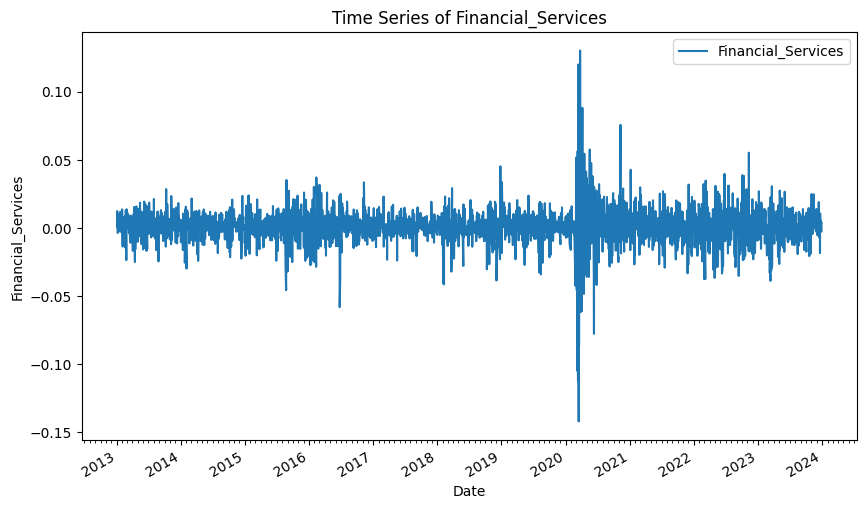

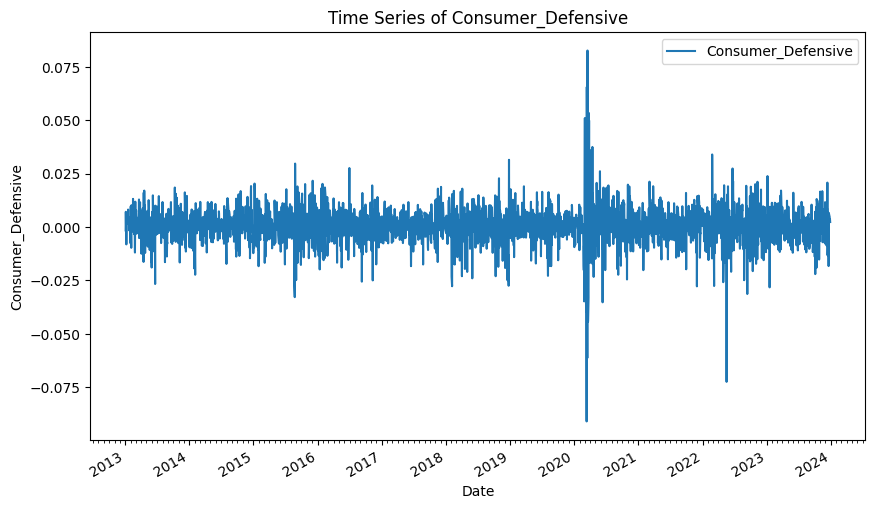

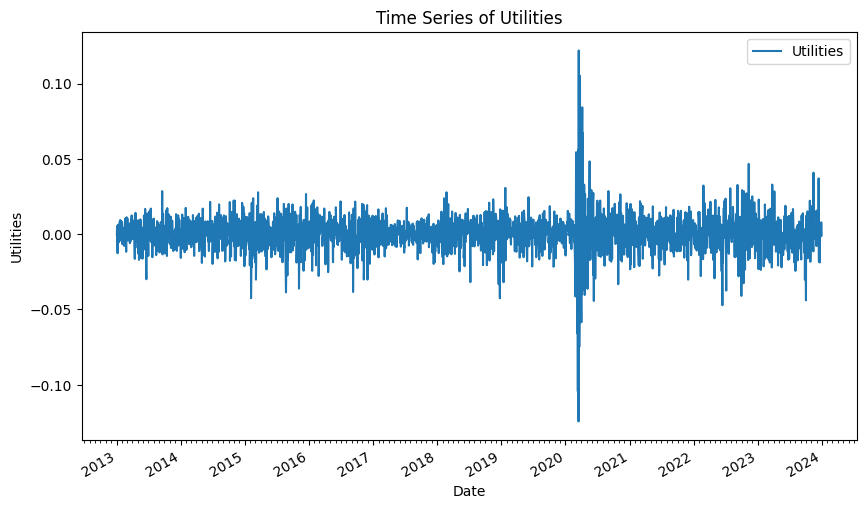

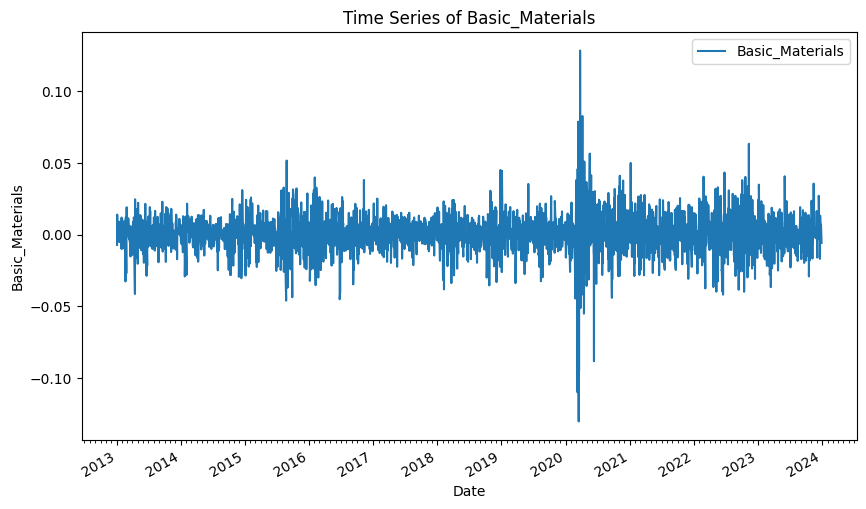

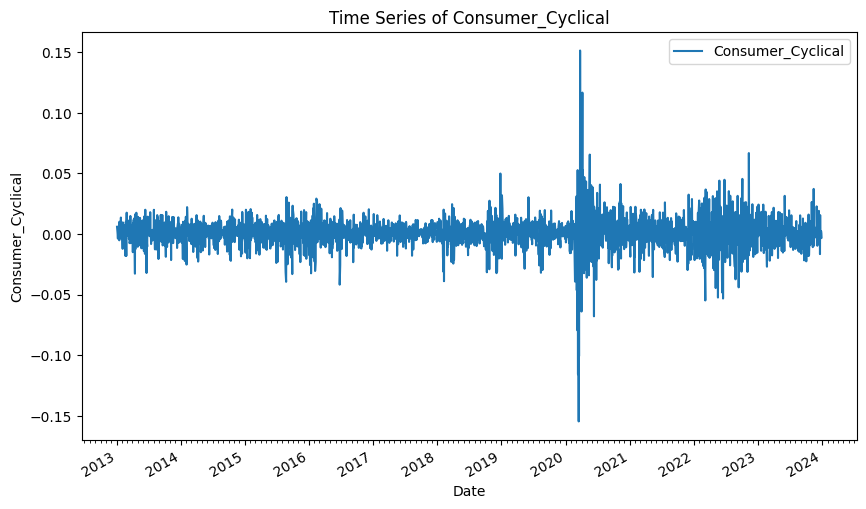

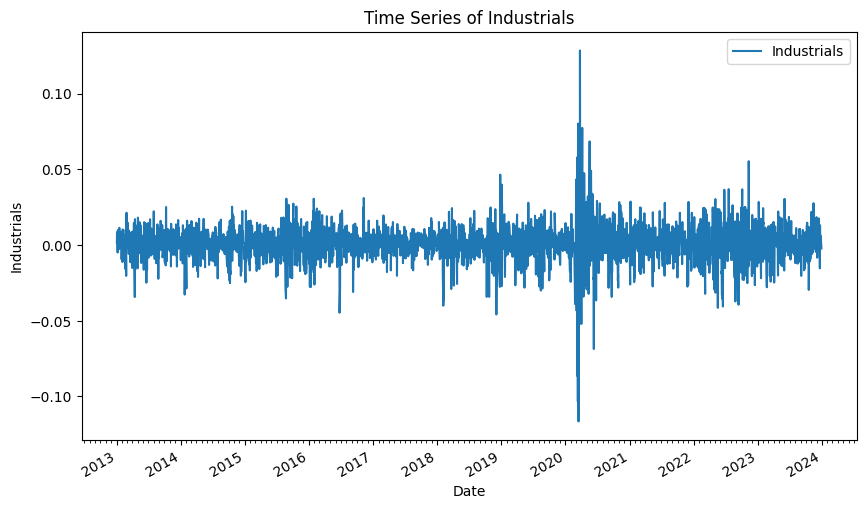

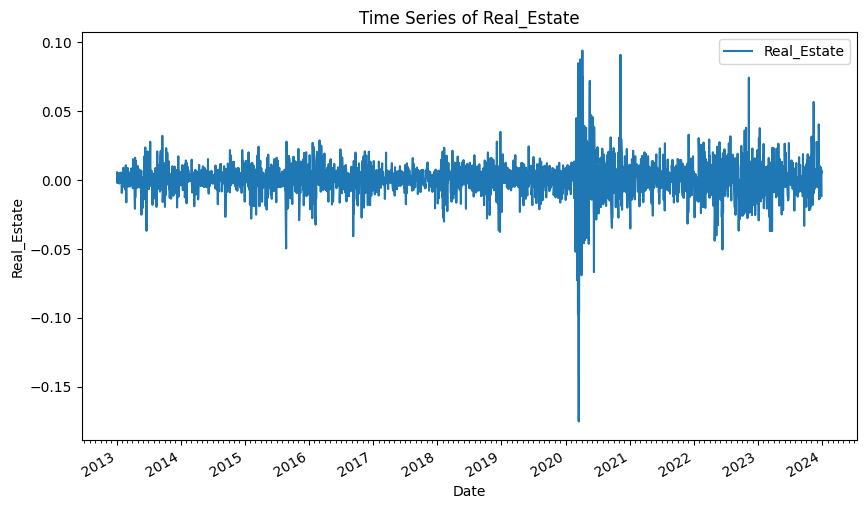

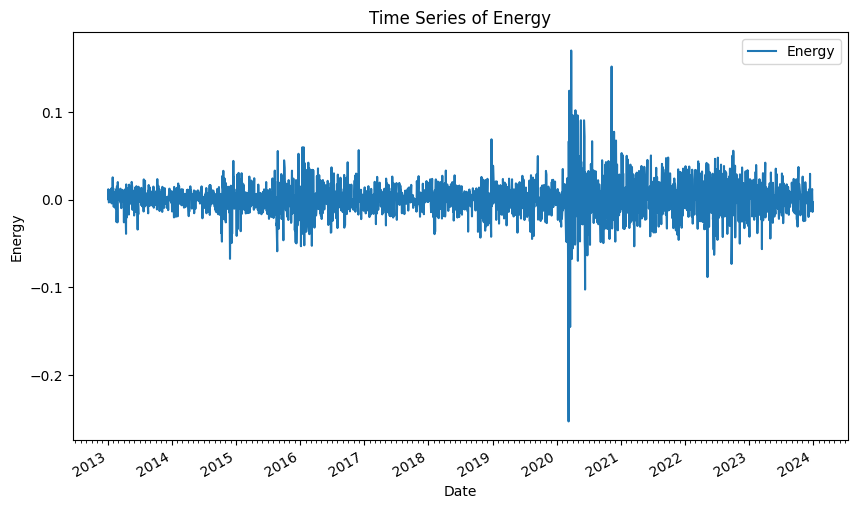

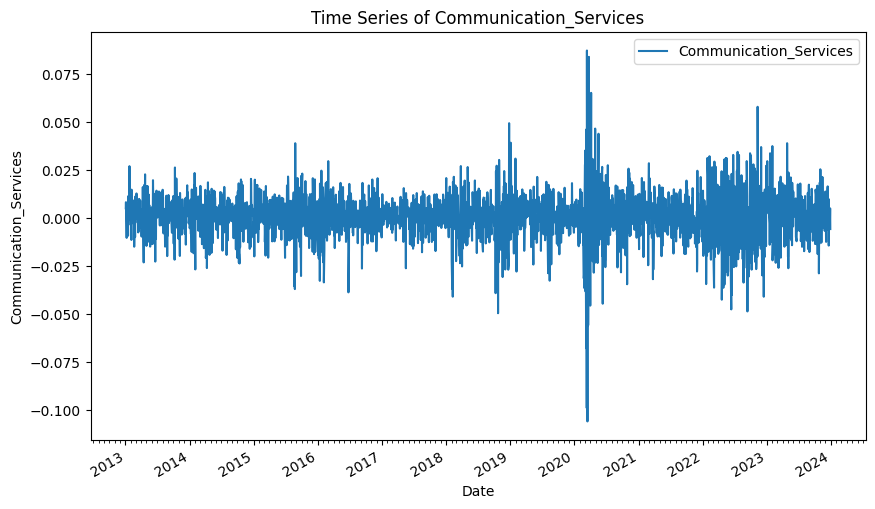

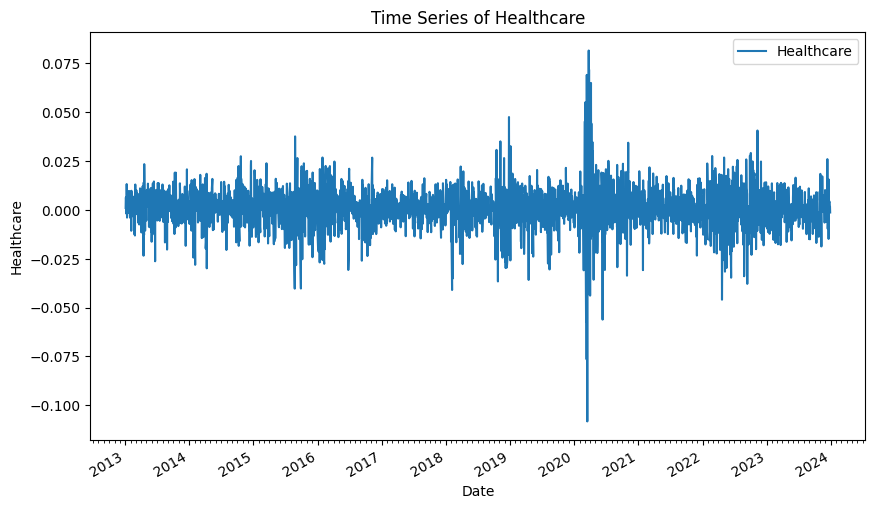

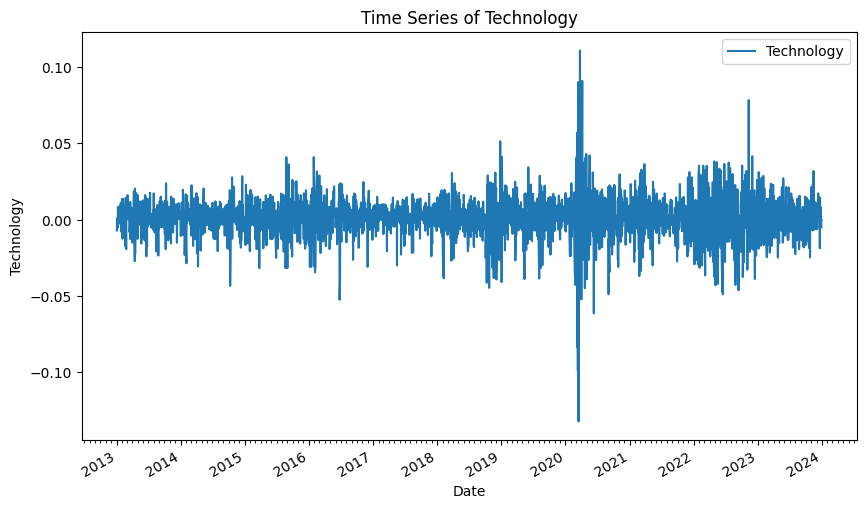

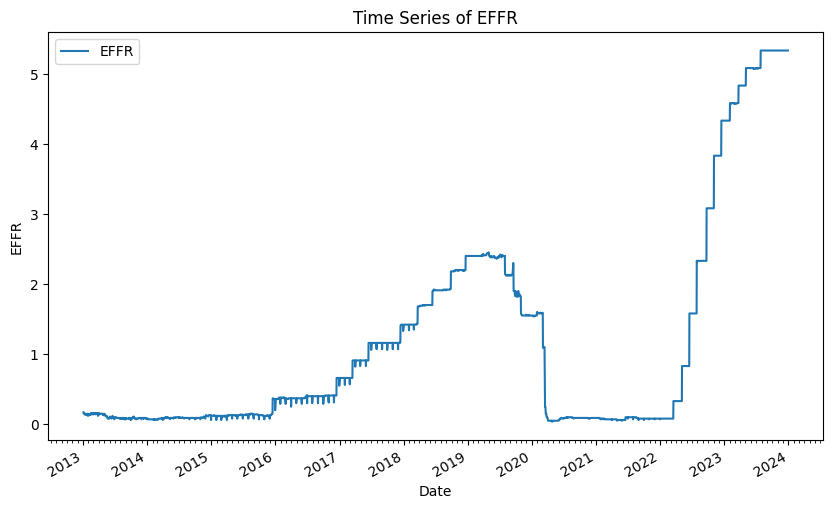

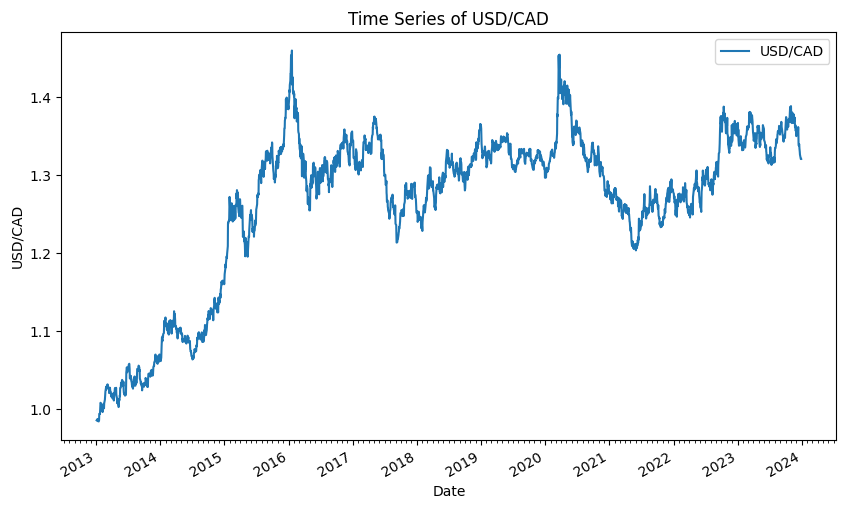

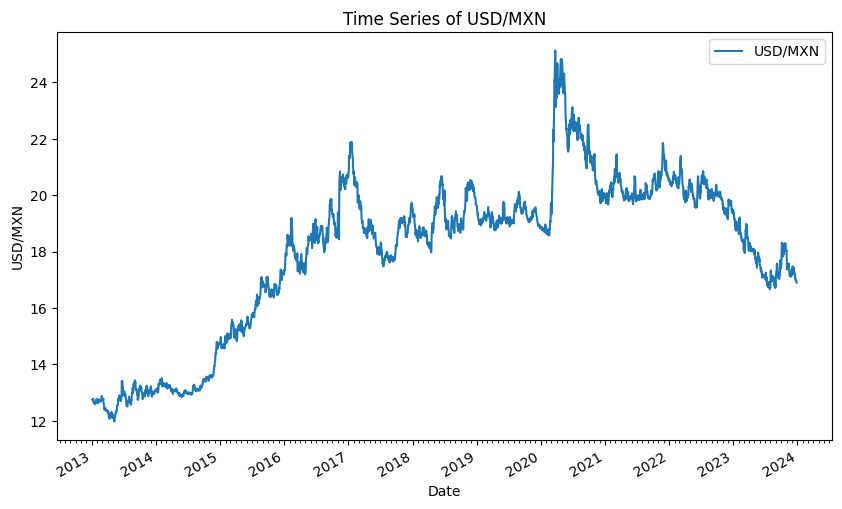

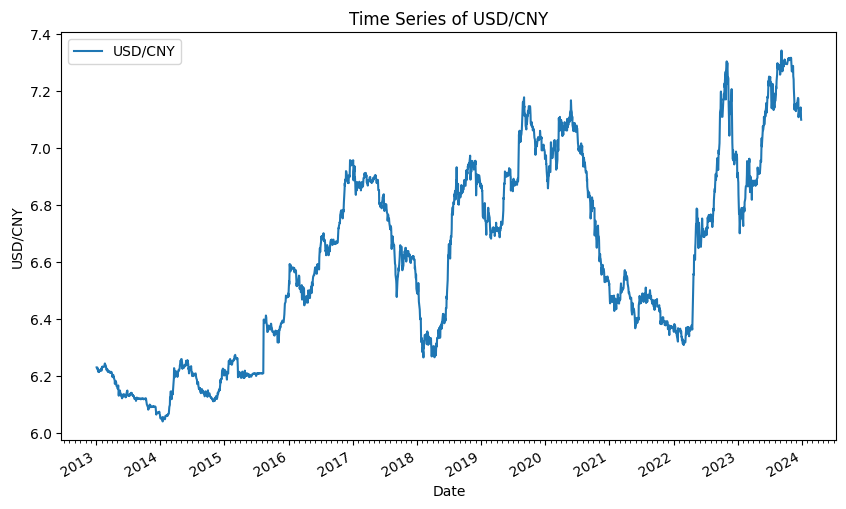

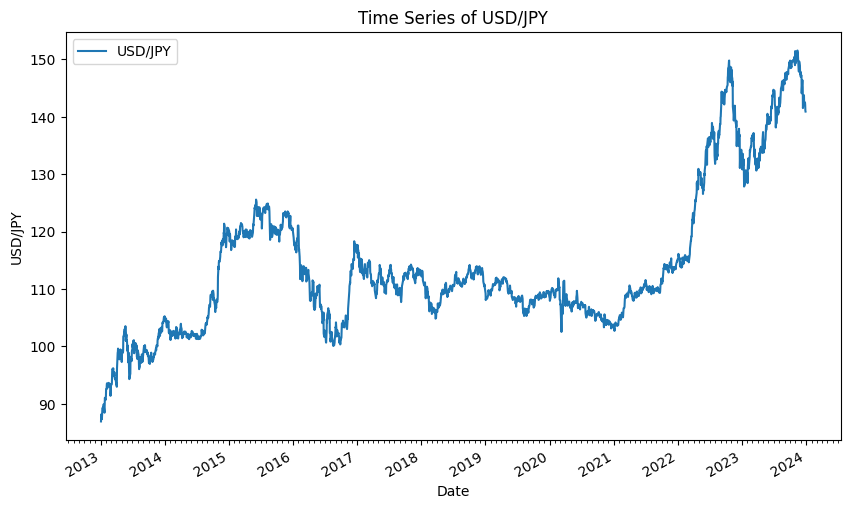

In [167]:
import matplotlib.dates as mdates

# Ensure 'Date' is in datetime format
final['Date'] = pd.to_datetime(final['Date'])

# Plot time series for each numeric column
numeric_columns = final.iloc[:, 1:].columns

# Plot time series
for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    plt.plot(final['Date'], final[column], label=column)
    plt.title(f"Time Series of {column}")
    plt.xlabel('Date')
    plt.ylabel(column)

    # Format x-axis to show only years
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks at each year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as 'YYYY'
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Optional: Minor ticks at each month
    plt.gcf().autofmt_xdate()  # Rotate and format the x-axis labels

    plt.legend()
    plt.show()



## 시계열 데이터에 이어, 수익률의 분포를 나타낸다.
- 왜도, 첨도까지 표시. 확실히 다들 정규분포가 아님을 알 수 있다.

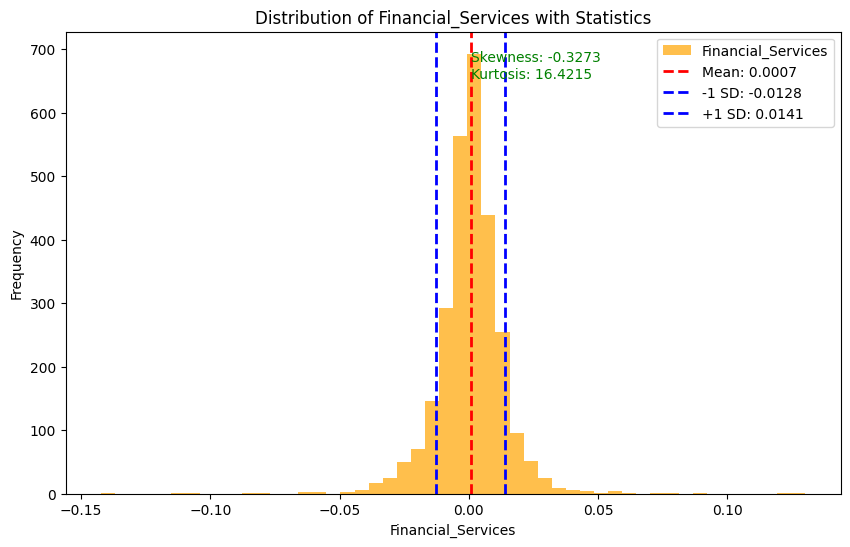

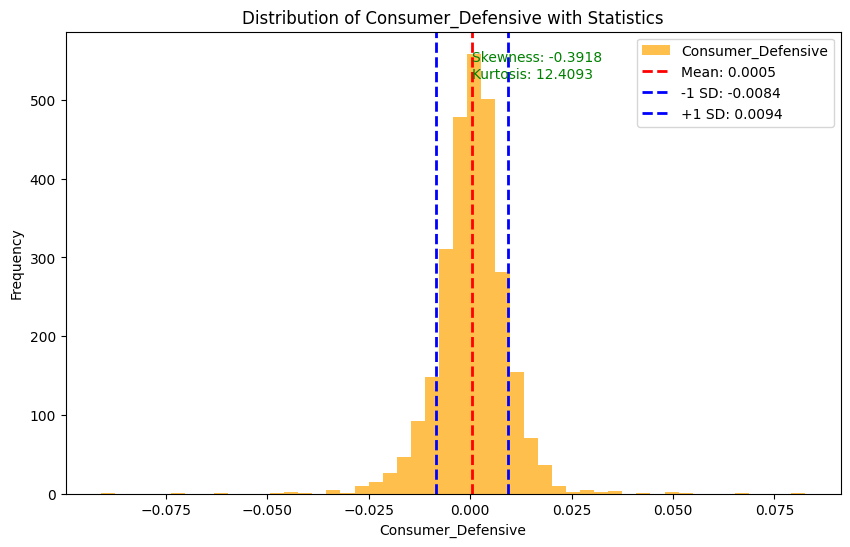

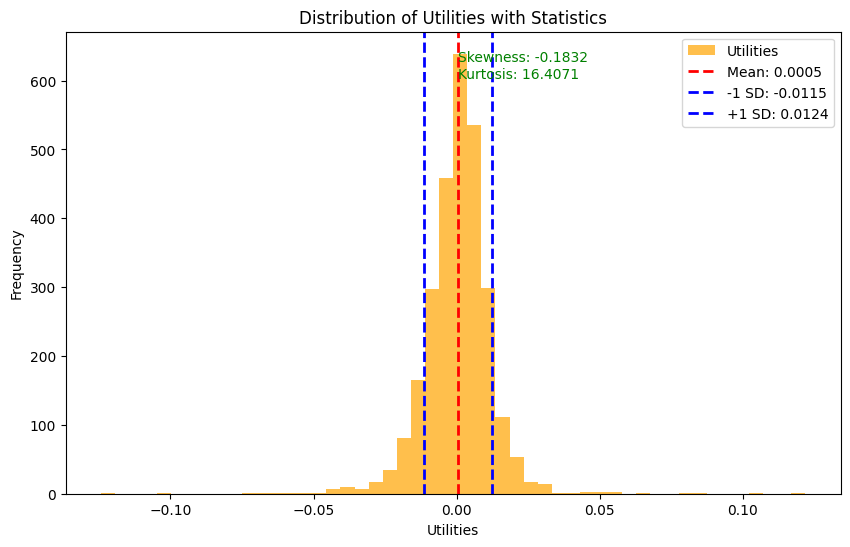

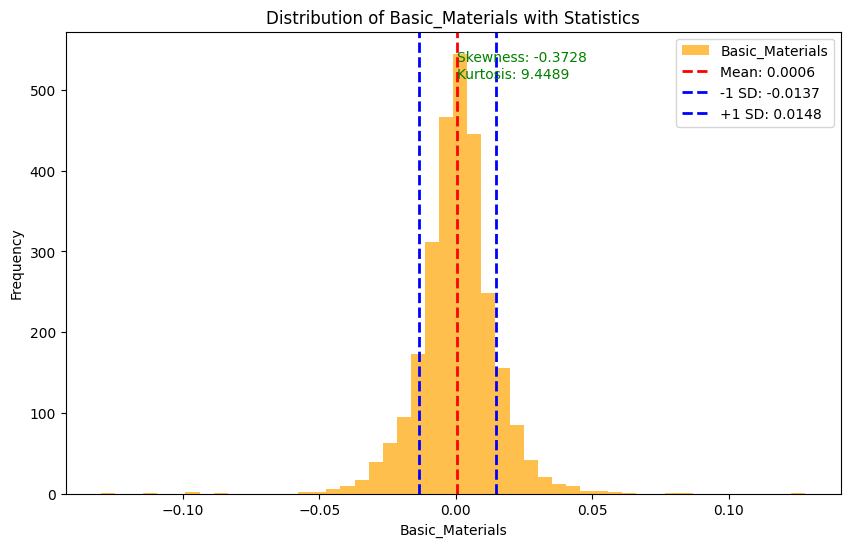

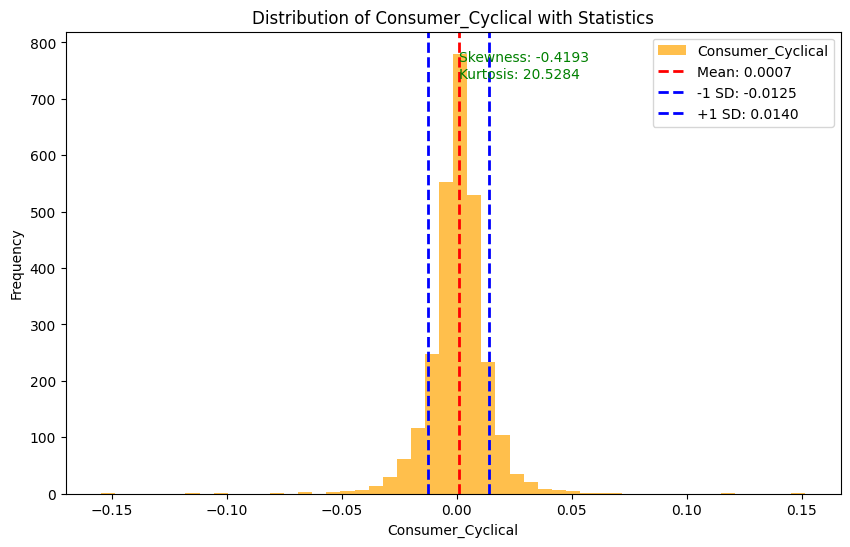

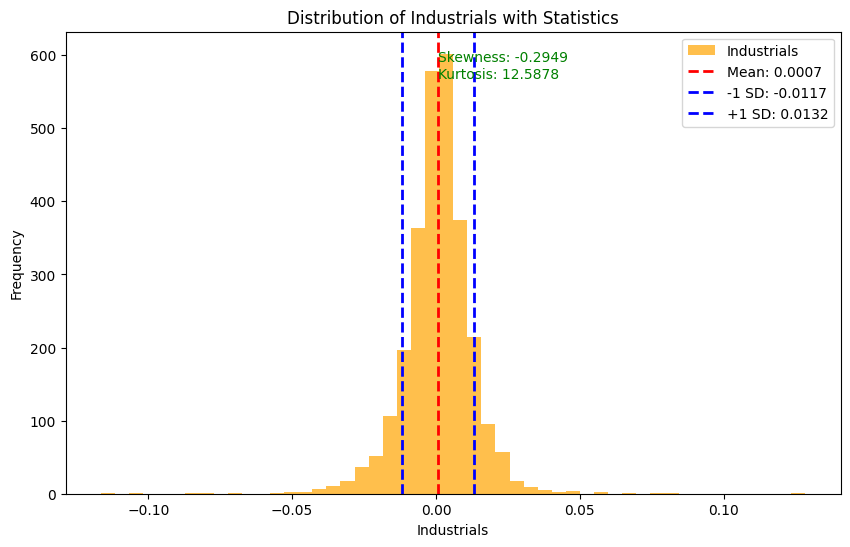

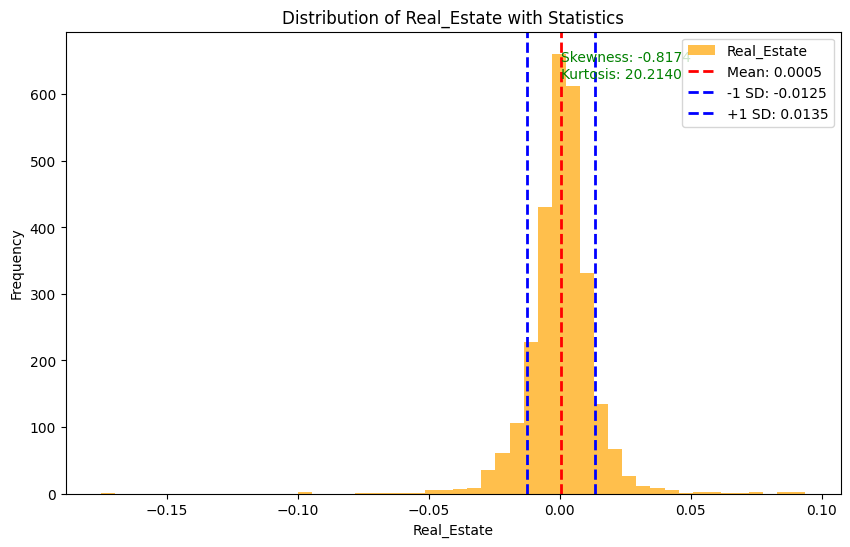

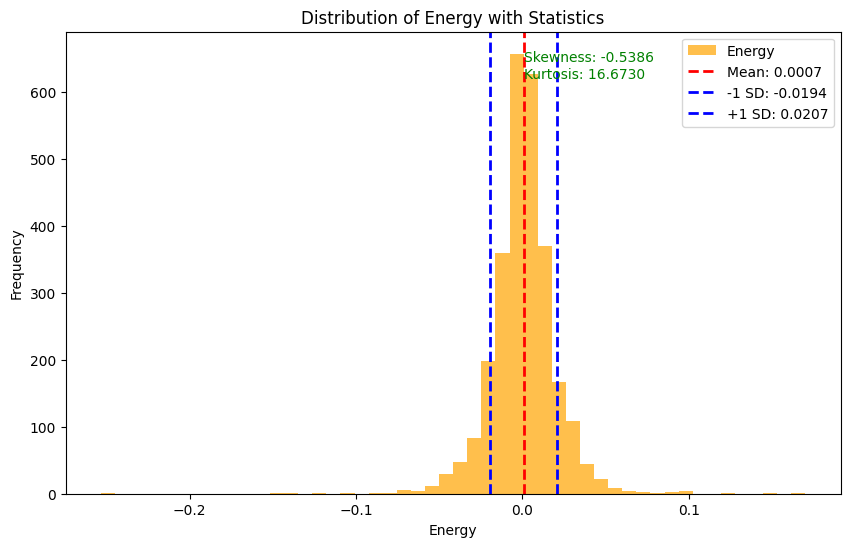

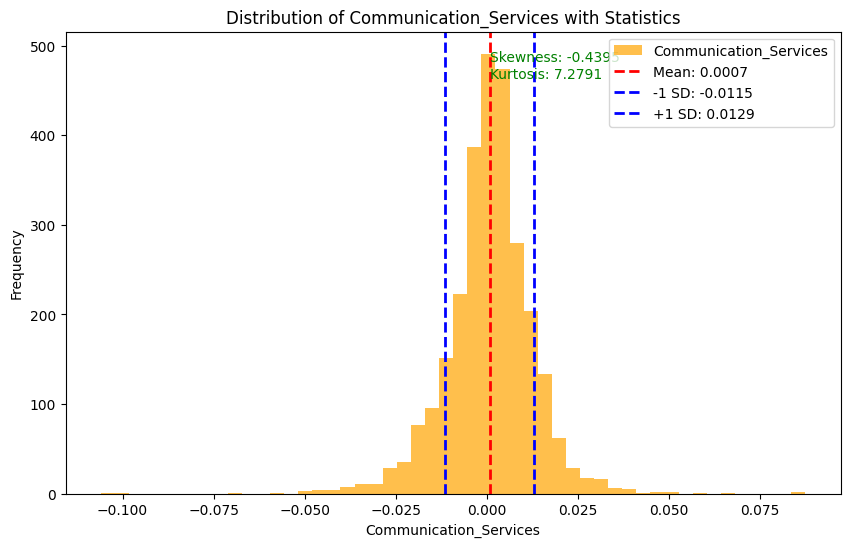

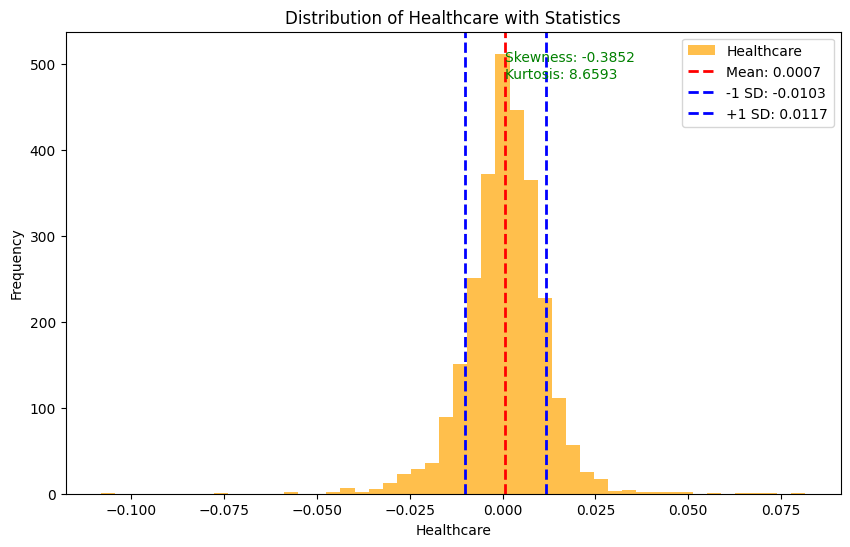

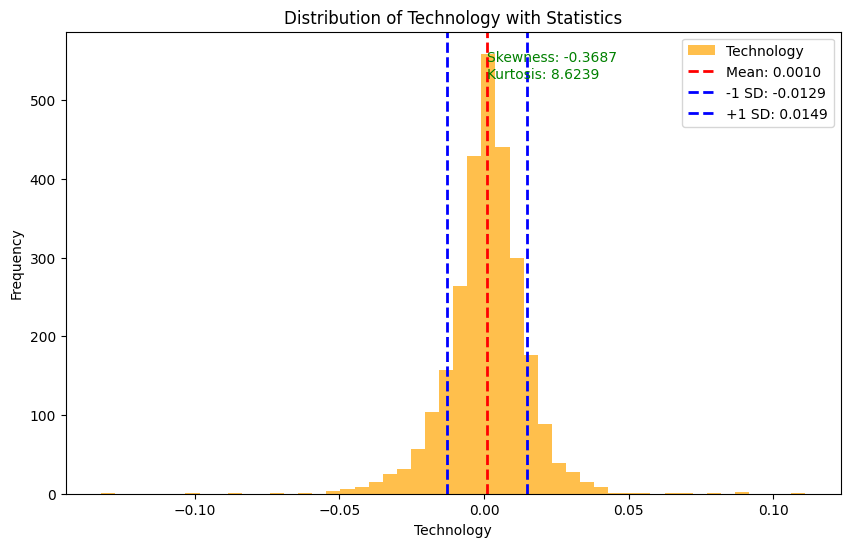

In [158]:

# Filter sector columns (excluding non-sector numeric columns like EFFR and FX rates)
sector_columns = [col for col in numeric_columns if col not in ['EFFR', 'USD/CAD', 'USD/MXN', 'USD/CNY', 'USD/JPY']]


# Plot distribution with mean, standard deviation, skewness, and kurtosis
for column in sector_columns:
    data = final[column].dropna()
    mean_val = data.mean()
    std_val = data.std()
    skewness = skew(data)
    kurt = kurtosis(data)

    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, alpha=0.7, label=f"{column}", color='orange')
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.4f}")
    plt.axvline(mean_val - std_val, color='blue', linestyle='dashed', linewidth=2, label=f"-1 SD: {mean_val - std_val:.4f}")
    plt.axvline(mean_val + std_val, color='blue', linestyle='dashed', linewidth=2, label=f"+1 SD: {mean_val + std_val:.4f}")
    plt.title(f"Distribution of {column} with Statistics")
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.text(mean_val, plt.ylim()[1]*0.9, f"Skewness: {skewness:.4f}\nKurtosis: {kurt:.4f}", fontsize=10, color='green')
    plt.show()

## 앞서 시계열 자료를 보완하기 위한 추가적인 시각화

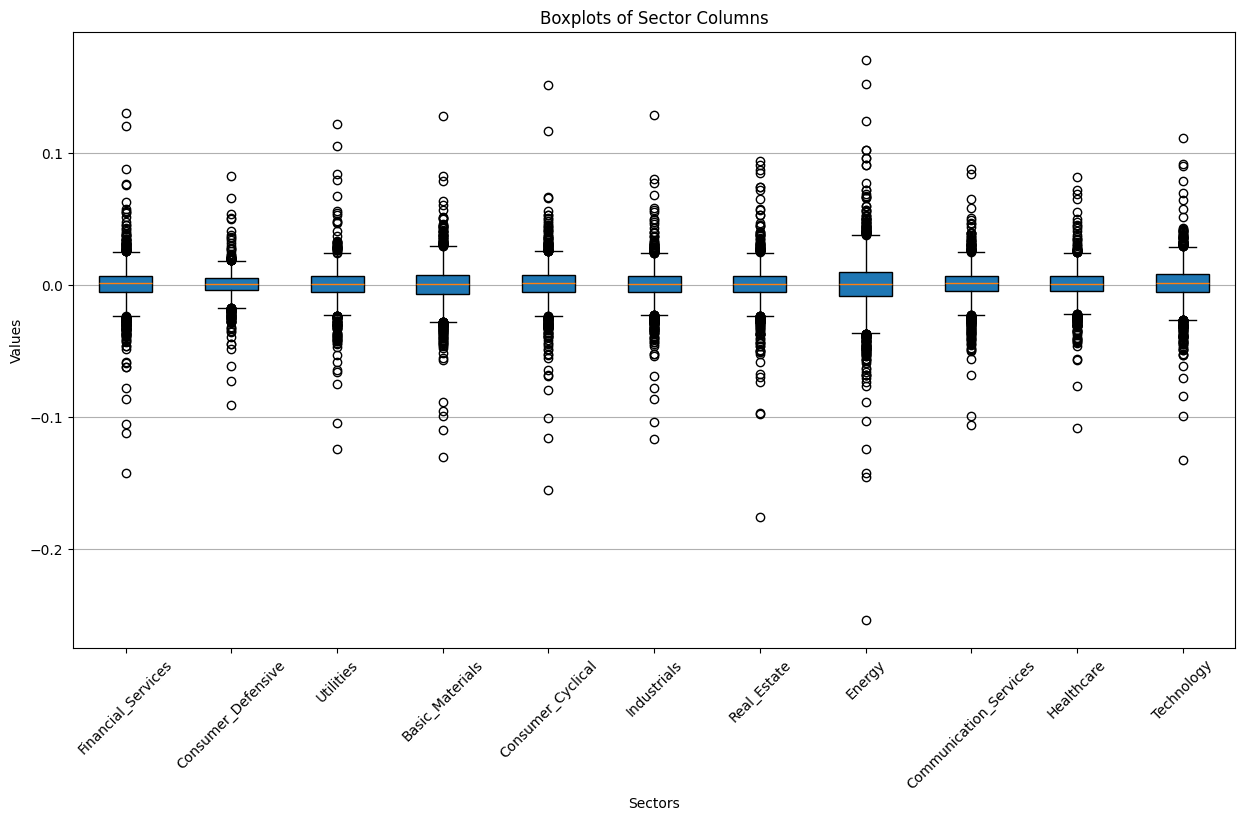

In [160]:
# Draw boxplots for all sector columns
plt.figure(figsize=(15, 8),)
plt.boxplot([final[col].dropna() for col in sector_columns], labels=sector_columns, patch_artist=True,)
plt.title("Boxplots of Sector Columns")
plt.xlabel("Sectors")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## 그리고 describe 를 통한 quantile 확인

In [162]:
final.iloc[:,0:11].describe()

,Financial_Services,Consumer_Defensive,Utilities,Basic_Materials,Consumer_Cyclical,Industrials,Real_Estate,Energy,Communication_Services,Healthcare
count,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000
mean,0.000675,0.000497,0.000466,0.000597,0.000738,0.000745,0.000486,0.000654,0.000721,0.000729
std,0.013427,0.008905,0.011921,0.014250,0.013237,0.012444,0.012989,0.020058,0.012179,0.010986
min,-0.142375,-0.091085,-0.124334,-0.130097,-0.154777,-0.116489,-0.175333,-0.253412,-0.105948,-0.108247
25%,-0.005278,-0.003915,-0.005207,-0.006475,-0.004965,-0.004955,-0.005310,-0.008649,-0.004903,-0.004645
50%,0.001168,0.000838,0.000944,0.000866,0.001154,0.001139,0.000965,0.000487,0.001220,0.001012
75%,0.006976,0.005095,0.006535,0.007884,0.007206,0.006797,0.006627,0.009996,0.007004,0.006857
max,0.130214,0.082649,0.121941,0.128173,0.151530,0.128438,0.093778,0.170134,0.087412,0.081597


## 가장 확인해보고 싶었던 상관관계. Heatmap 을 사용했다.

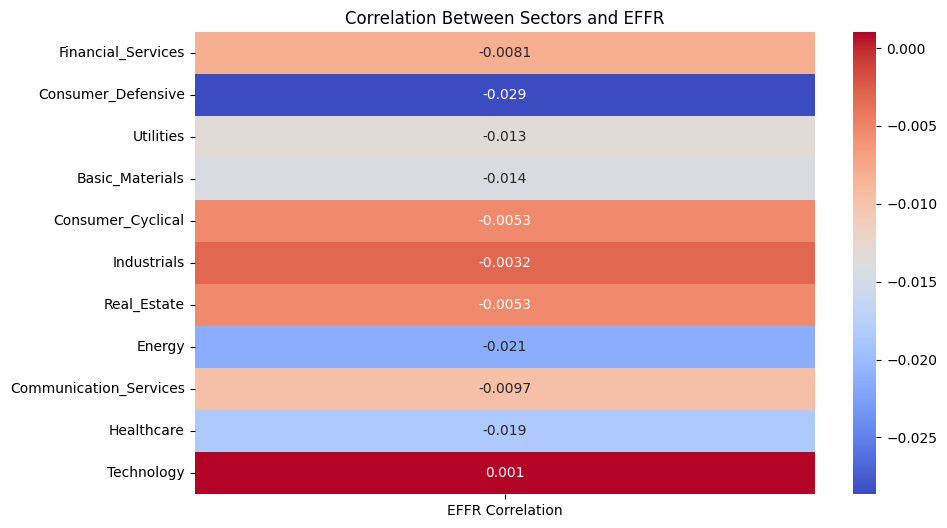

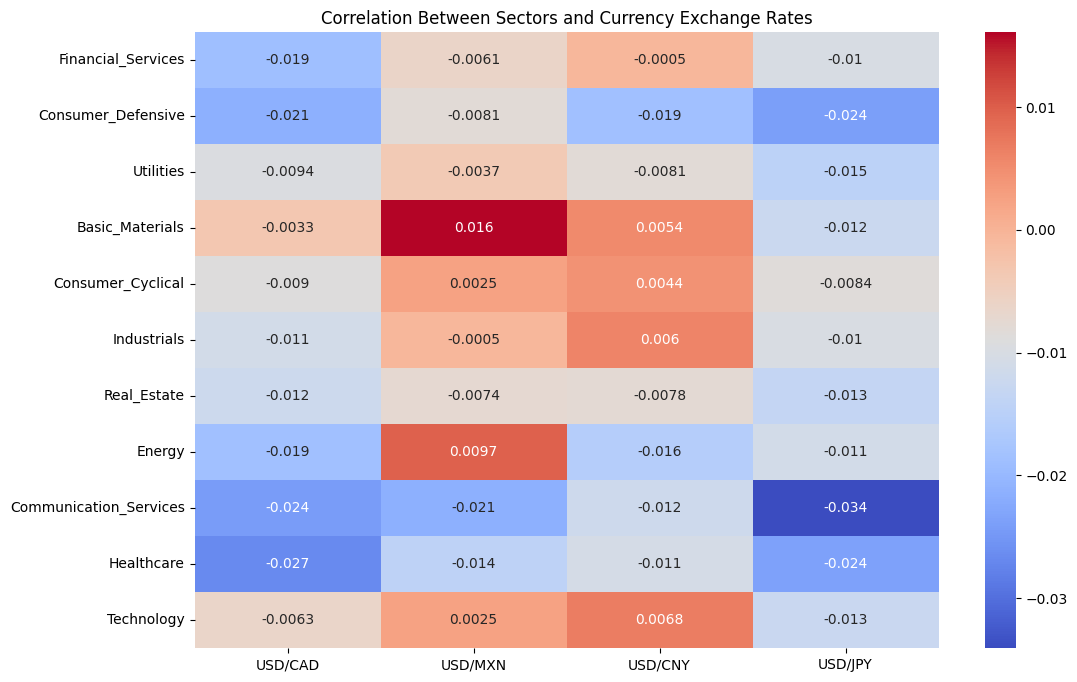

In [169]:
# Calculate correlation between sectors' daily returns and EFFR
effr_corr = final[sector_columns + ['EFFR']].corr()['EFFR'].drop('EFFR')

# Calculate correlation between sectors' daily returns and currency exchange rates
fx_columns = ['USD/CAD', 'USD/MXN', 'USD/CNY', 'USD/JPY']
fx_corr = final[sector_columns + fx_columns].corr()

# Extract correlations for FX rates with sectors
fx_corr_sectors = fx_corr.loc[sector_columns, fx_columns]

# Plot heatmap for correlation with EFFR
plt.figure(figsize=(10, 6))
sns.heatmap(effr_corr.to_frame(name="EFFR Correlation"), annot=True, cmap='coolwarm', cbar=True)
plt.title("Correlation Between Sectors and EFFR")
plt.show()

# Plot heatmap for correlation with FX rates
plt.figure(figsize=(12, 8))
sns.heatmap(fx_corr_sectors, annot=True, cmap='coolwarm', cbar=True)
plt.title("Correlation Between Sectors and Currency Exchange Rates")
plt.show()